# Plot example hydrophone spectrograms computed using STFT for the 3 components of a list of stations

In [125]:
# Imports
from os.path import join
from matplotlib.pyplot import subplots
from matplotlib.dates import DateFormatter
from matplotlib.dates import MinuteLocator, SecondLocator
from matplotlib.patches import Rectangle
from pandas import Timestamp, Timedelta
from numpy import log10

from utils_basic import ROOTDIR_HYDRO, GEO_COMPONENTS, VELOCITY_UNIT, days_to_timestamps, save_figure
from utils_preproc import read_and_process_windowed_hydro_waveforms
from utils_spec import get_spectrogram_stft

In [126]:
# Inputs
## Data
stations_to_plot = ["B00"]
locations_to_plot = ["01", "02", "03", "04", "05", "06"]
starttime = Timestamp("2020-01-13T19:35:00Z")
dur = 120.0
window_length = 1.0 # seconds
rootdir = ROOTDIR_HYDRO

## Plotting
ylim_wf = (-0.2, 0.2)
ylim_freq = (0.0, 200.0)

dbmin = -70.0
dbmax = 0.0

linewidth_wf = 0.5

linewidth_box = 1.5

xdim_ax = 6.0
ydim_ax = 3.0

timemin_box = Timestamp("2020-01-13T19:36:20Z")
timemax_box = Timestamp("2020-01-13T19:36:35Z")

freqmin_box = 60.0
freqmax_box = 120.0

In [127]:
# Read the waveforms
stream = read_and_process_windowed_hydro_waveforms(starttime, dur, stations=stations_to_plot, locations=locations_to_plot)

In [128]:
# Compute the spectrograms
specdict = {}

for station in stations_to_plot:
    for location in locations_to_plot:
        trace = stream.select(station=station, location=location)[0]
        data = trace.data
        samprat = trace.stats.sampling_rate

        freqax, timeax, spec = get_spectrogram_stft(data, window_length=window_length, overlap=0.5)

        specdict[(station, location)] = (freqax, timeax, spec)

Figure saved to /Volumes/OmanData/data/geophones/hydro_spectrogram_stft_2020-01-13-19-35-00_dur120s.png


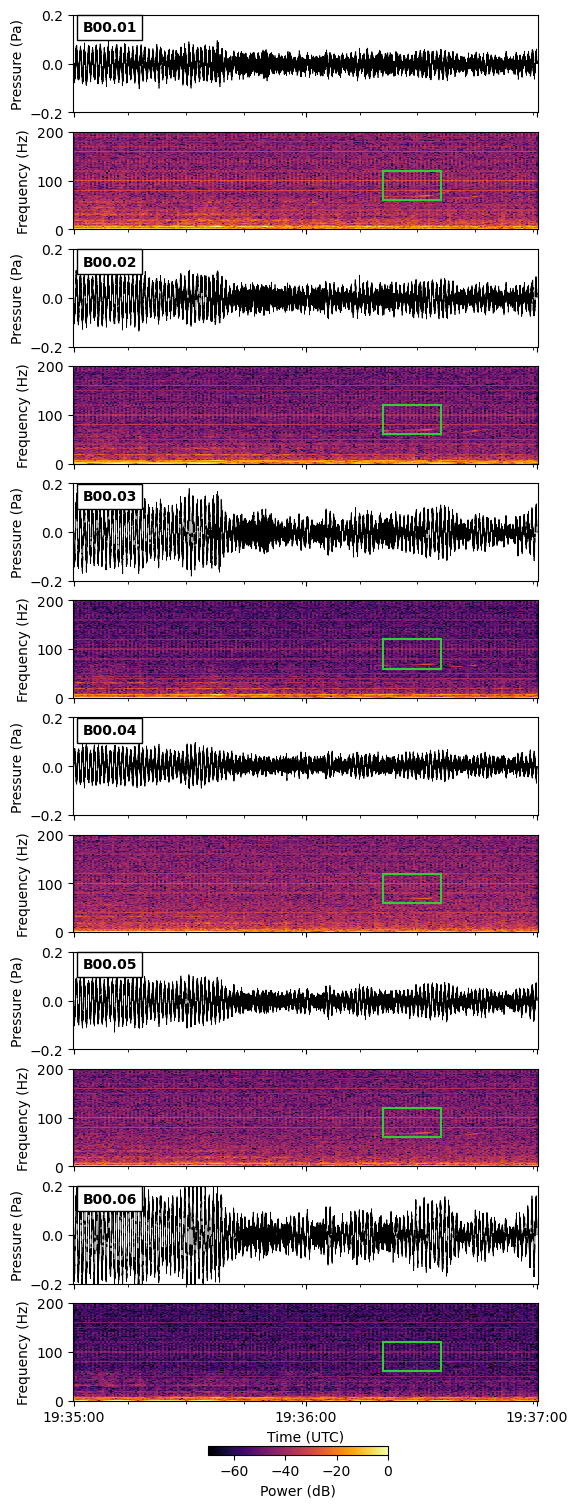

In [129]:
# Plot the waveforms and spectrograms
numsta = len(stations_to_plot)
numloc = len(locations_to_plot)
fig, axes = subplots(2 * numloc, numsta, figsize=(xdim_ax * numsta, ydim_ax * numloc), sharex=True)

for i, station in enumerate(stations_to_plot):
    for j, location in enumerate(locations_to_plot):
        
        ## Plot the waveform
        trace = stream.select(station=station, location=location)[0]
        data = trace.data
        timeax_wf = trace.times("matplotlib")
        timeax_wf = days_to_timestamps(timeax_wf)

        if numsta == 1:
            ax = axes[2 * j]
        else:
            ax = axes[2 * j, i]

        ax.plot(timeax_wf, data, "black", linewidth=linewidth_wf)
        ax.set_ylim(ylim_wf)

        if i == 0:
            ax.set_ylabel(f"Pressure (Pa)")

        ## Label the location
        ax.text(0.02, 0.94, f"{station}.{location}", transform=ax.transAxes, va="top", ha="left", fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=1.0))

        ## Plot the spectrogram
        if numsta == 1:
            ax = axes[2 * j + 1]
        else:
            ax = axes[2 * j + 1, i]
            
        freqax, timeax_spec, spec = specdict[(station, location)]
        timeax_spec = [timeax_wf[0] + Timedelta(seconds=t) for t in timeax_spec]
        cmap = ax.pcolormesh(timeax_spec, freqax, spec, cmap="inferno", vmin=dbmin, vmax=dbmax)

        ## Add the box encompassing the time-frequency region of interest
        box = Rectangle((timemin_box, freqmin_box), timemax_box - timemin_box, freqmax_box - freqmin_box, linewidth=linewidth_box, edgecolor="limegreen", facecolor="none")
        ax.add_patch(box)

        ## Set the major tick spacing to 1 minute
        ax.xaxis.set_major_locator(MinuteLocator(interval=1))
        ax.xaxis.set_minor_locator(SecondLocator(interval=15))

        ## Set the frequency limits
        ax.set_ylim(ylim_freq)
            
        ## Set the axis labels
        if i == 0:
            ax.set_ylabel("Frequency (Hz)")

        if j == numloc - 1:
            ax.set_xlabel("Time (UTC)")
            ax.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))


# Add a horizontal colorbar below the bottom subplot
cax = fig.add_axes([0.35, 0.08, 0.3, 0.005])  # [left, bottom, width, height]
fig.colorbar(cmap, cax=cax, orientation='horizontal', label="Power (dB)")

# Save the figure
timestr = starttime.strftime("%Y-%m-%d-%H-%M-%S")
figname = f"hydro_spectrogram_stft_{timestr}_dur{dur:.0f}s.png"

save_figure(fig, figname)